In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal, Dirichlet, Multinomial, Gamma
from tensorflow.contrib.linalg import LinearOperatorTriL
import itertools
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')
import bijectors as bijector

from plot_utils import * # see plot_utils.py
from keras.layers import Dense

import pandas as pd
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
def generator(arrays, batch_size):
    """Generate batches, one with respect to each array's first axis."""
    starts = [0] * len(arrays)  # pointers to where we are in iteration
    while True:
        batches = []
        for i, array in enumerate(arrays):
            start = starts[i]
            stop = start + batch_size
            diff = stop - array.shape[0]
            if diff <= 0:
                batch = array[start:stop]
                starts[i] += batch_size
            else:
                batch = np.concatenate((array[start:], array[:diff]))
                starts[i] = diff
            batches.append(batch)
        yield batches

In [3]:
D = 2
K = 2
N = 1000
M = 100

In [4]:
x_ph = tf.placeholder(tf.float32, [None,D])

In [5]:
mean_precision_shape,mean_precision_rate,obs_precision_shape,obs_precision_rate = 4.,200.,6.,10.

# p model
alpha = 1
pi = Dirichlet(np.atleast_1d(alpha*np.ones(K)).astype(np.float32))
#pi = tf.nn.softmax(np.random.normal(size=D).astype(np.float32)).eval()
z = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(pi,[M]),[M,K]))
sigma2_mu_k = ed.models.InverseGamma([mean_precision_shape],[mean_precision_rate])
sigma2_mu_d = ed.models.InverseGamma(mean_precision_shape*tf.ones([D]),mean_precision_rate*tf.ones([D]))
sigma2_mu = tf.reshape(tf.tile(sigma2_mu_k, [K]), [K,1])*sigma2_mu_d
mu = ed.models.MultivariateNormalDiag(tf.zeros([K,D]), tf.sqrt(sigma2_mu))
sigma2_obs_n = ed.models.InverseGamma([obs_precision_shape],[obs_precision_rate])
sigma2_obs_d = ed.models.InverseGamma(obs_precision_shape*tf.ones([D]),obs_precision_rate*tf.ones([D]))
sigma2_obs = tf.reshape(tf.tile(sigma2_obs_n, [M]), [M,1])*sigma2_obs_d
x = ed.models.MultivariateNormalDiag(tf.matmul(z, mu), tf.sqrt(sigma2_obs))

Pmodel = (z, sigma2_mu_k, sigma2_mu_d, mu, sigma2_obs_n, sigma2_obs_d)

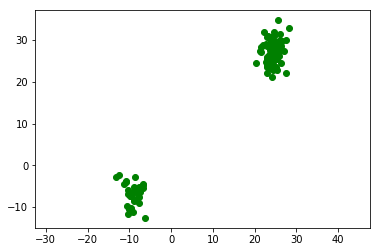

In [6]:
sess = tf.Session()
with sess.as_default():
    init = tf.global_variables_initializer()
    init.run()
    X_sample = x.sample().eval()
    plt.scatter(*X_sample.T,color='g')
    plt.axis('equal');

### standardize

In [7]:
X_sample_mean = X_sample.mean(0)
X_sample_std = X_sample.std(0)
X_sample -= X_sample_mean
X_sample /= X_sample_std

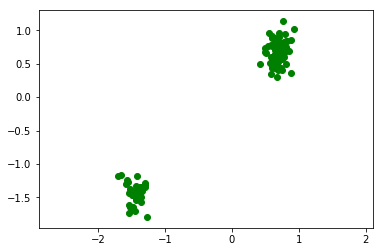

In [8]:
plt.scatter(*X_sample.T,color='g')
plt.axis('equal');

In [9]:
# q model
#alpha_hat = 1 + tf.nn.softplus(tf.Variable(tf.random_normal([K])))
#qpi = Dirichlet(alpha_hat)

hidden = Dense(256, activation='tanh')(x_ph)
#hidden = Dense(256, activation='relu')(x_ph)
qz = Multinomial(total_count=1.,probs=Dense(K, activation='softmax')(hidden))

#qz = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(qpi,[M]),[M,K]))
#qz = Multinomial(total_count=1.,probs=qpi)

mean_precision_shape_hat = tf.Variable(tf.random_normal([1]))
mean_precision_rate_hat = tf.nn.softplus(tf.Variable(tf.random_normal([1])))
qsigma2_mu_k = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(mean_precision_shape_hat,mean_precision_rate_hat),
    bijector=bijector.Exp(),
    name="qsigma2_mu_k")
qsigma2_mu_d = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(mean_precision_shape_hat*tf.ones([D]),mean_precision_rate_hat*tf.ones([D])),
    bijector=bijector.Exp(),
    name="qsigma2_mu_d")
qsigma2_mu = tf.reshape(tf.tile(qsigma2_mu_k, [K]), [K,1])*qsigma2_mu_d

qmu_mean = tf.Variable(tf.zeros([K,D]))
qmu = ed.models.MultivariateNormalDiag(qmu_mean, tf.sqrt(qsigma2_mu))

obs_precision_shape_hat = tf.Variable(tf.random_normal([1]))
obs_precision_rate_hat = tf.nn.softplus(tf.Variable(tf.random_normal([1])))
qsigma2_obs_n = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(obs_precision_shape_hat,obs_precision_rate_hat),
    bijector=bijector.Exp(),
    name="qsigma2_obs_n")
qsigma2_obs_d = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(obs_precision_shape_hat*tf.ones([D]),obs_precision_rate_hat*tf.ones([D])),
    bijector=bijector.Exp(),
    name="qsigma2_obs_d")
qsigma2_obs = tf.reshape(tf.tile(qsigma2_obs_n, [M]), [M,1])*qsigma2_obs_d

Qmodel = (qz, qsigma2_mu_k, qsigma2_mu_d, qmu, qsigma2_obs_n, qsigma2_obs_d)

In [10]:
data = generator([X_sample], M)
n_batch = int(N / M)

In [11]:
dict(zip(Pmodel,Qmodel))

{<ed.RandomVariable 'InverseGamma/' shape=(1,) dtype=float32>: <ed.RandomVariable 'qsigma2_mu_k/' shape=(1,) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_1/' shape=(2,) dtype=float32>: <ed.RandomVariable 'qsigma2_mu_d/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_2/' shape=(1,) dtype=float32>: <ed.RandomVariable 'qsigma2_obs_n/' shape=(1,) dtype=float32>,
 <ed.RandomVariable 'MultivariateNormalDiag/' shape=(2, 2) dtype=float32>: <ed.RandomVariable 'MultivariateNormalDiag_2/' shape=(2, 2) dtype=float32>,
 <ed.RandomVariable 'Multinomial/' shape=(100, 2) dtype=float32>: <ed.RandomVariable 'Multinomial_1/' shape=(?, 2) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_3/' shape=(2,) dtype=float32>: <ed.RandomVariable 'qsigma2_obs_d/' shape=(2,) dtype=float32>}

In [12]:
inference = ed.KLqp(dict(zip(Pmodel,Qmodel)), data={x: x_ph})
inference.initialize(n_iter=5000, n_print=100, n_samples=1000, optimizer='rmsprop')

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

{'loss': 5523.1577, 't': 1}
{'loss': 4392.0122, 't': 1001}
{'loss': 1820.4695, 't': 2001}
{'loss': 1524.8491, 't': 3001}
{'loss': 842.59631, 't': 4001}


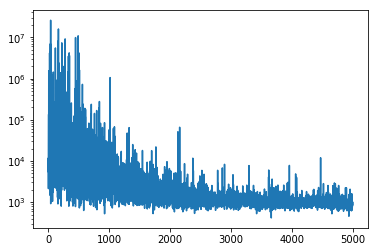

In [13]:
learning_curve = []
for _ in range(inference.n_iter):
    x_batch = next(data)[0]
    #print(hidden.eval({x_ph:x_batch}))
    #print(qz.sample().eval({x_ph:x_batch}))
    info_dict = inference.update({x_ph: x_batch})
    if _%1000 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
plt.semilogy(learning_curve)

In [ ]:
print(qz.sample().eval({x_ph:x_batch}))

In [ ]:
x_post = ed.copy(x, dict(zip(Pmodel,Qmodel)))
foo = x_post.sample().eval({x_ph:x_batch})
foo *= X_sample_std
foo += X_sample_mean
sess = tf.Session()
with sess.as_default():
    init = tf.global_variables_initializer()
    init.run()
    plt.scatter(*foo.T,color='g')
    plt.axis('equal');